* 整理自链接： https://hrl.boyuai.com/chapter/2/dqn%E6%94%B9%E8%BF%9B%E7%AE%97%E6%B3%95

&&  https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/

**倒立摆环境**可以比较方便地**验证 DQN 对值的过高估计**：倒立摆环境下 $Q$ 值的最大估计应为 0（倒立摆向上保持直立时能选取的最大 $Q$ 值），$Q$ 值出现大于 0 的情况则说明出现了过高估计。

为了能够应用 DQN，我们采用离散化动作的技巧。例如，下面的代码将连续的动作空间离散为 11 个动作。动作 $[0,1,2,\cdots,9,10]$ 分别代表力矩为 $[-2,-1.6,-1.2,\cdots,1.2,1.6,2]$。


* 倒立摆**向上保持直立不动**时奖励为 0，在其他位置时奖励为**负数**。

# Code

In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 30.0 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 这样 无需 plt.show()  直接在代码单元下方显示图
from tqdm import tqdm
import random
import collections
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

##   类模块

### 经验回放

* 加入数据
* 采样数据

In [3]:
class ReplayBuffer:
  """ 经验回放池"""
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)  # 队列，先进先出

  def add(self, state, action, reward, next_state, done): # 将 转换 加入 buffer
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size): # 从 buffer 中采样数据， 数量为 batch_size
    transitions = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*transitions)
    return np.array(state), action, reward, np.array(next_state), done

  def size(self): # 目前 buffer 中数据的数量
    return len(self.buffer)

### VAnet (状态价值函数 + 优势函数 ——> Q)

DQN： Q 网络 (一层隐藏层)

In [4]:
class VAnet(torch.nn.Module):
  """ 只有一层隐藏层 的 A 网络 和 V 网络"""

  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim) # 共享网络
    self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_V = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x):
    A = self.fc_A(F.relu(self.fc1(x)))
    V = self.fc_V(F.relu(self.fc1(x)))
    Q = V + A - A.mean(1).view(-1,1)
    return Q

### Dueling DQN 算法

In [5]:
class Dueling_DQN:
  """ Dueling DQN 算法"""
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
    self.action_dim = action_dim
    # Dueling DQN 换掉网络架构
    # Q 网络
    self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
    # 目标网络
    self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)

    # DQN 的网络
    # Q 网络
    # self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
    # # 目标网络
    # self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)

    # 使用 Adam 优化器
    self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
    self.gamma = gamma # 折扣因子
    self.epsilon = epsilon  # ε- greedy 策略的参数 (以 概率 ε随机选择动作， 以概率 1-ε执行动作价值最大的动作 )
    self.target_update = target_update  # 目标网络 更新频率
    self.count = 0 # 计数器，用于记录 在线网络 Q 的更新次数， 若是间隔达到 C 次，更新目标网络参数
    self.device = device

  def take_action(self, state): # 遵循 ε- greedy 策略 选取动作
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.action_dim)
    else:
      state = torch.tensor([state], dtype=torch.float).to(self.device)
      action = self.q_net(state).argmax().item()
    return action

  def max_q_value(self, state):  # 用于 可视化 Q 的高估
    state = torch.tensor([state],dtype=torch.float).to(self.device)
    return self.q_net(state).max().item() # 最大的 Q 值

  def update(self, transition_dict): # 每回合 更新一次
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device) # view(-1, 1) 数据维度修改为 1 列， 行数自适应
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

    q_values = self.q_net(states).gather(1, actions)  #  整合动作的价值
    # 下个状态的最大 动作价值 Q_max

    # DDQN 的动作通过 Q 网络获取 ！！！
    # max_action = self.q_net(next_states).max(1)[1].view(-1,1)
    # max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
    # DQN
    max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)  # # A.max(1)返回 A 每一行最大值组成的一维数组


    q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # r + γ max(s_{t+1}, a_{t+1})
    dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
    self.optimizer.zero_grad()  # 梯度重置为 0
    dqn_loss.backward() # 反向传播
    self.optimizer.step() # 更新

    if self.count % self.target_update == 0: # 在线网络 Q 又更新了 C 次
      # 更新 目标网路 参数
      self.target_q_net.load_state_dict(self.q_net.state_dict())
    self.count += 1

## 训练


环境链接： https://gymnasium.farama.org/environments/classic_control/pendulum/

In [6]:
# Create and wrap the environment
env_name = "Pendulum-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值

total_num_episodes = 200  # 回合总数 M
hidden_dim = 128
learning_rate = 1e-2    # 学习率
gamma = 0.98       # 折扣因子 γ
epsilon = 0.01       # ε-greedy 策略的参数 ε
target_update = 50     # C： 目标网络 的更新周期
buffer_size = 5000   # 回放缓存区的容量 N
minimal_size = 1000   # 有一定量的数据再开始 更新 Q 网络
batch_size = 64  # 小批次 数据量
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# Observation-space of
state_dim = env.observation_space.shape[0]
# Action-space of
action_dim = 11  # 将连续动作分成 11 个离散动作

def dis_to_con(discrete_action, env, action_dim):
  action_lowbound = env.action_space.low[0] # 连续动作的最小值
  action_upbound = env.action_space.high[0]  # 连续动作的最大值
  return action_lowbound + (discrete_action /(action_dim - 1)) * (action_upbound - action_lowbound)


# 训练过程会记录下每个状态的最大 Q 值

rewards_over_seeds = []
max_q_value_over_seeds = []

for seed in [0, 42, 2024, 10, 15]:  #  seeds
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    replay_buffer = ReplayBuffer(buffer_size)
    # Reinitialize agent every seed
    agent = Dueling_DQN(state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon,
           target_update, device)
    reward_over_episodes = []
    max_q_value_over_episodes = []
    max_q_value = 0
    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        state, info = wrapped_env.reset(seed=seed)
        done = False
        while not done:
            action = agent.take_action(state)

            max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
            max_q_value_over_episodes.append(max_q_value)  # 保存每个状态的最大Q值
            action_continuous = dis_to_con(action, env, agent.action_dim)

            next_state, reward, terminated, truncated, info = wrapped_env.step([action_continuous])
            done = terminated or truncated
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state

            if replay_buffer.size() > minimal_size: ## 当 buffer 数据的数量超过一定值后,才进行 Q 网络训练。数据越多，去相关性 效果越好
              b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size) # 抽取 小批次 回放数据，用于更新 Q 网络
              transition_dict = {
                  'states': b_s,
                  'actions': b_a,
                  'next_states': b_ns,
                  'rewards': b_r,
                  'dones': b_d
              }
              agent.update(transition_dict)

        reward_over_episodes.append(wrapped_env.return_queue[-1])

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)
    max_q_value_over_seeds.append(max_q_value_over_episodes)

# Pendulum-v1
# 奖励的值在 -16 ~ 0
# 回合长度阈值为 200


Episode: 0 Average Reward: -1594
Episode: 0 Average Reward: -184
Episode: 0 Average Reward: -211
Episode: 0 Average Reward: -195
Episode: 0 Average Reward: -330


## 可视化

https://seaborn.pydata.org/generated/seaborn.lineplot.html

[Text(0.5, 1.0, 'Dueling DQN for Pendulum-v1')]

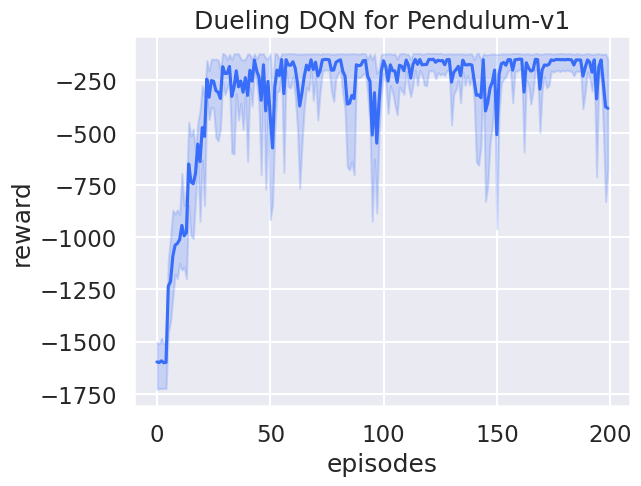

In [11]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="Dueling DQN for {}".format(env_name)
)

[Text(0.5, 1.0, 'Dueling DQN for Pendulum-v1')]

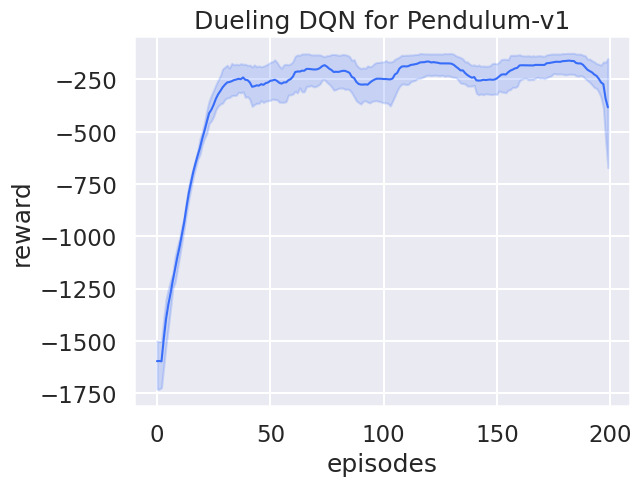

In [12]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[ reward for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 19) # 调这里 更改平滑度

df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="Dueling DQN for {}".format(env_name)
)   # 调线宽

# Pendulum-v1
# 奖励的值在 -16 ~ 0
# 回合长度阈值为 200

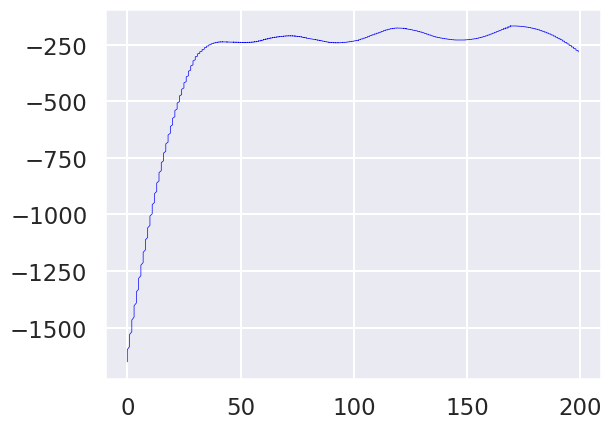

In [13]:
from scipy.signal import savgol_filter
%matplotlib inline

# 应用平滑滤波器
window_size = 300  # 窗口大小，即平滑的程度
polyorder = 2     # 多项式的阶数

# 对 y 值使用 savgol_filter
smoothed_y = savgol_filter(df1['reward'], window_length=window_size, polyorder=polyorder)

# 绘制平滑后的线图
plt.plot(df1['episodes'], smoothed_y, color='blue', linewidth=0.5)   # 2

In [10]:
print(YES!)  # 用于中断程序运行

SyntaxError: invalid syntax (<ipython-input-10-3d07cdce9072>, line 1)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd /content/drive/MyDrive/DQNs-Test
!ls

# 在 目录 /content/drive/MyDrive 下新建一个文件夹 DQNs-Test

/content/drive/MyDrive/DQNs-Test
DQNs_df_CartPole-v1.csv  DQNs_max_q_values_Pendulum-v1.csv	DQNs_rewards_Pendulum-v1_DQN.csv
DQNs_df_copy.csv	 DQNs_max_q_values_Pendulum-v1_DQN.csv
DQNs_df.csv		 DQNs_rewards_Pendulum-v1.csv


In [18]:
my_df1  = pd.read_csv('/content/drive/MyDrive/DQNs-Test/DQNs_rewards_Pendulum-v1.csv', index_col=0)   # index_col=0 指定行索引的位置
# 暂存之前的数据
my_df1.to_csv('/content/drive/MyDrive/DQNs-Test/DQNs_rewards_Pendulum-v1_DQN+DDQN.csv')
my_df1

,DQN,DDQN
0,-1596.309705,-1518.106287
1,-1586.631166,-1511.718340
2,-1576.990614,-1505.350233
3,-1567.388047,-1499.001966
4,-1557.823467,-1492.673540
...,...,...
995,-260.258192,-313.784143
996,-260.900190,-314.278581
997,-261.546308,-314.774483
998,-262.196545,-315.271849


In [19]:
# 新增一列
my_df1["Dueling DQN"] = smoothed_y
my_df1

,DQN,DDQN,Dueling DQN
0,-1596.309705,-1518.106287,-1650.438065
1,-1586.631166,-1511.718340,-1636.846120
2,-1576.990614,-1505.350233,-1623.317409
3,-1567.388047,-1499.001966,-1609.851932
4,-1557.823467,-1492.673540,-1596.449688
...,...,...,...
995,-260.258192,-313.784143,-276.322308
996,-260.900190,-314.278581,-277.866099
997,-261.546308,-314.774483,-279.420794
998,-262.196545,-315.271849,-280.986391


In [20]:
my_df1.to_csv("/content/drive/MyDrive/DQNs-Test/DQNs_rewards_Pendulum-v1.csv")

In [22]:
new_df  = pd.read_csv('/content/drive/MyDrive/DQNs-Test/DQNs_rewards_Pendulum-v1.csv', index_col=0)   # index_col=0 指定行索引的位置
new_df

,DQN,DDQN,Dueling DQN
0,-1596.309705,-1518.106287,-1650.438065
1,-1586.631166,-1511.718340,-1636.846120
2,-1576.990614,-1505.350233,-1623.317409
3,-1567.388047,-1499.001966,-1609.851932
4,-1557.823467,-1492.673540,-1596.449688
...,...,...,...
995,-260.258192,-313.784143,-276.322308
996,-260.900190,-314.278581,-277.866099
997,-261.546308,-314.774483,-279.420794
998,-262.196545,-315.271849,-280.986391


[Text(0.5, 1.0, 'Comparison of rewards on Pendulum-v1')]

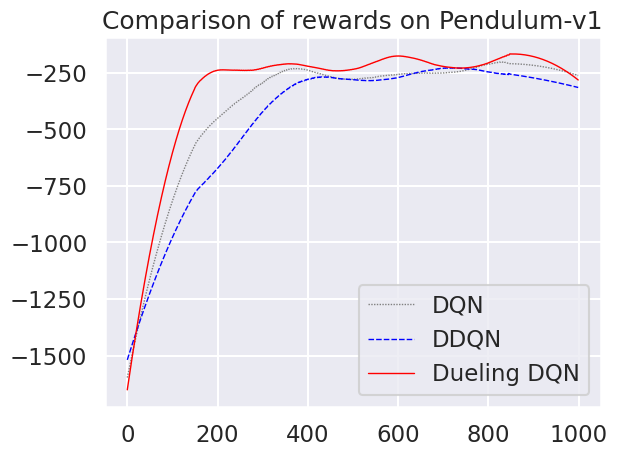

In [42]:
# 绘图比较
 # , palette={'DQN':'blue','DDQN':'red'},style_order=['DDQN','DQN']
sns.lineplot(data=new_df, linewidth=1, palette={'DQN':'gray','DDQN':'blue','Dueling DQN':'red'},style_order=['Dueling DQN','DDQN','DQN']).set(
    title="Comparison of rewards on {}".format(env_name)
)

### Q 值 可视化

[Text(0.5, 1.0, 'Dueling DQN for Pendulum-v1')]

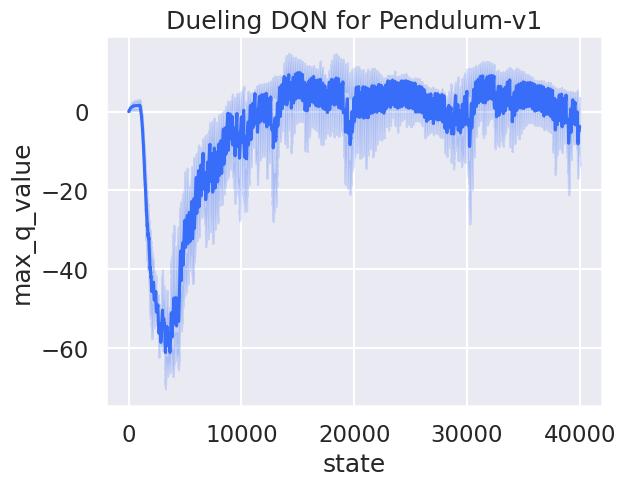

In [14]:
import pandas as pd
import seaborn as sns

max_q_values_to_plot = [[ max_q_value  for max_q_value in max_q_values] for max_q_values in max_q_value_over_seeds]

df1 = pd.DataFrame(max_q_values_to_plot).melt()
df1.rename(columns={"variable": "state", "value": "max_q_value"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="state", y="max_q_value", data=df1).set(
    title="Dueling DQN for {}".format(env_name)
)


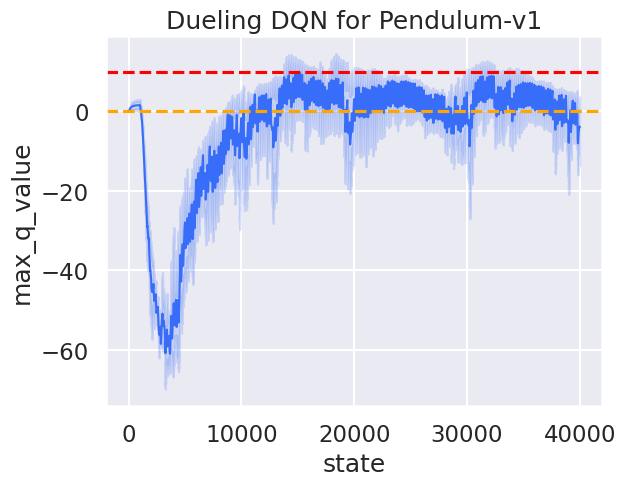

In [15]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

max_q_values_to_plot = [[ max_q_value  for max_q_value in max_q_values] for max_q_values in max_q_value_over_seeds]
# print(rewards_to_plot)
for i in range(len(max_q_values_to_plot)):
  max_q_values_to_plot[i] = moving_average(max_q_values_to_plot[i], 19) # 调这里 更改平滑度

df1 = pd.DataFrame(max_q_values_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "state", "value": "max_q_value"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
ax = sns.lineplot(x="state", y="max_q_value", data=df1, linewidth=1.5).set(
    title="Dueling DQN for {}".format(env_name)
)   # 调线宽

# 添加横线
plt.axhline(0, color='orange', linestyle='--')
plt.axhline(10, color='red', linestyle='--')

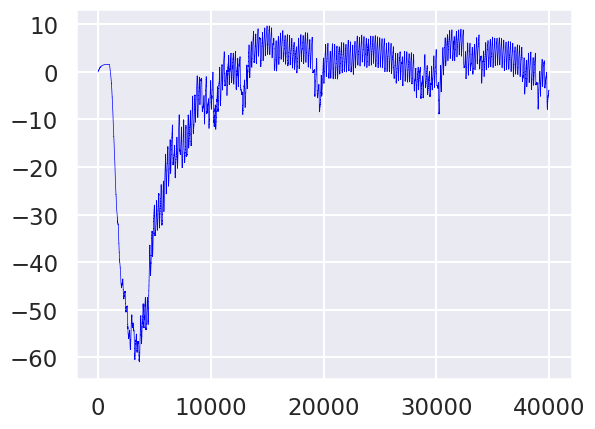

In [33]:
from scipy.signal import savgol_filter
%matplotlib inline

# 应用平滑滤波器
window_size = 300  # 窗口大小，即平滑的程度
polyorder = 2     # 多项式的阶数

# 对 y 值使用 savgol_filter
smoothed_y = savgol_filter(df1["max_q_value"], window_length=window_size, polyorder=polyorder)

# 绘制平滑后的线图
plt.plot(df1['state'], smoothed_y, color='blue', linewidth=0.5)   # 2

# 将训练结果 存到 本地， 方便后续 DQN 和 DDQN 进行比较 (DataFrame && csv)


https://pandas.pydata.org/docs/user_guide/10min.html#importing-and-exporting-data

In [ ]:
print(YES!)

In [31]:
# 数据来自

my_df1  = pd.read_csv('/content/drive/MyDrive/DQNs-Test/DQNs_max_q_values_Pendulum-v1.csv', index_col=0)   # index_col=0 指定行索引的位置
# 暂存之前的数据
my_df1.to_csv('/content/drive/MyDrive/DQNs-Test/DQNs_max_q_values_Pendulum-v1__DQN+DDQN.csv')
my_df1

,DQN,DDQN
0,-0.007492,-0.007492
1,-0.006467,-0.006467
2,-0.005441,-0.005441
3,-0.004416,-0.004416
4,-0.003390,-0.003390
...,...,...
199995,4.999365,4.255024
199996,5.004779,4.257707
199997,5.010188,4.260379
199998,5.015592,4.263040


In [34]:
# 新增一列
my_df1["Dueling DQN"] = smoothed_y
my_df1

,DQN,DDQN,Dueling DQN
0,-0.007492,-0.007492,-0.012204
1,-0.006467,-0.006467,-0.010901
2,-0.005441,-0.005441,-0.009597
3,-0.004416,-0.004416,-0.008293
4,-0.003390,-0.003390,-0.006989
...,...,...,...
199995,4.999365,4.255024,-3.911269
199996,5.004779,4.257707,-3.913819
199997,5.010188,4.260379,-3.916410
199998,5.015592,4.263040,-3.919041


In [35]:
my_df1.to_csv("/content/drive/MyDrive/DQNs-Test/DQNs_max_q_values_Pendulum-v1.csv")

In [36]:
new_df1  = pd.read_csv('/content/drive/MyDrive/DQNs-Test/DQNs_max_q_values_Pendulum-v1.csv', index_col=0)   # index_col=0 指定行索引的位置
new_df1

,DQN,DDQN,Dueling DQN
0,-0.007492,-0.007492,-0.012204
1,-0.006467,-0.006467,-0.010901
2,-0.005441,-0.005441,-0.009597
3,-0.004416,-0.004416,-0.008293
4,-0.003390,-0.003390,-0.006989
...,...,...,...
199995,4.999365,4.255024,-3.911269
199996,5.004779,4.257707,-3.913819
199997,5.010188,4.260379,-3.916410
199998,5.015592,4.263040,-3.919041


[Text(0.5, 1.0, 'Comparison of rewards on Pendulum-v1')]

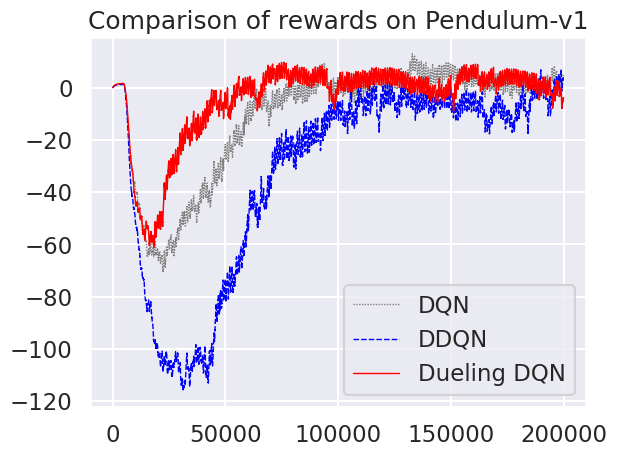

In [43]:
# 绘图比较
 # , palette={'DQN':'blue','DDQN':'red'},style_order=['DDQN','DQN']
sns.lineplot(data=new_df1, linewidth=1, palette={'DQN':'gray','DDQN':'blue','Dueling DQN':'red'},style_order=['Dueling DQN','DDQN','DQN']).set(
    title="Comparison of rewards on {}".format(env_name)
)